Libraries imported successfully
Dataset loaded: 140 rows, 18 columns

Columns: ['Age', 'Gender', 'StudyHours', 'SleepHours', 'ReviewCenter', 'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 'IncomeLevel', 'EmploymentStatus', 'Confidence', 'TestAnxiety', 'EnglishProficiency', 'MotivationScore', 'SocialSupport', 'ExamResultPercent', 'Passed']

Data Types:
Age                     int64
Gender                 object
StudyHours              int64
SleepHours              int64
ReviewCenter            int64
MockExamScore         float64
GPA                   float64
Scholarship             int64
InternshipGrade       float64
IncomeLevel            object
EmploymentStatus       object
Confidence              int64
TestAnxiety             int64
EnglishProficiency      int64
MotivationScore         int64
SocialSupport           int64
ExamResultPercent     float64
Passed                  int64
dtype: object

Output directory: ../correlation_analysis_dataset
DESCRIPTIVE STATISTICS SUMMARY

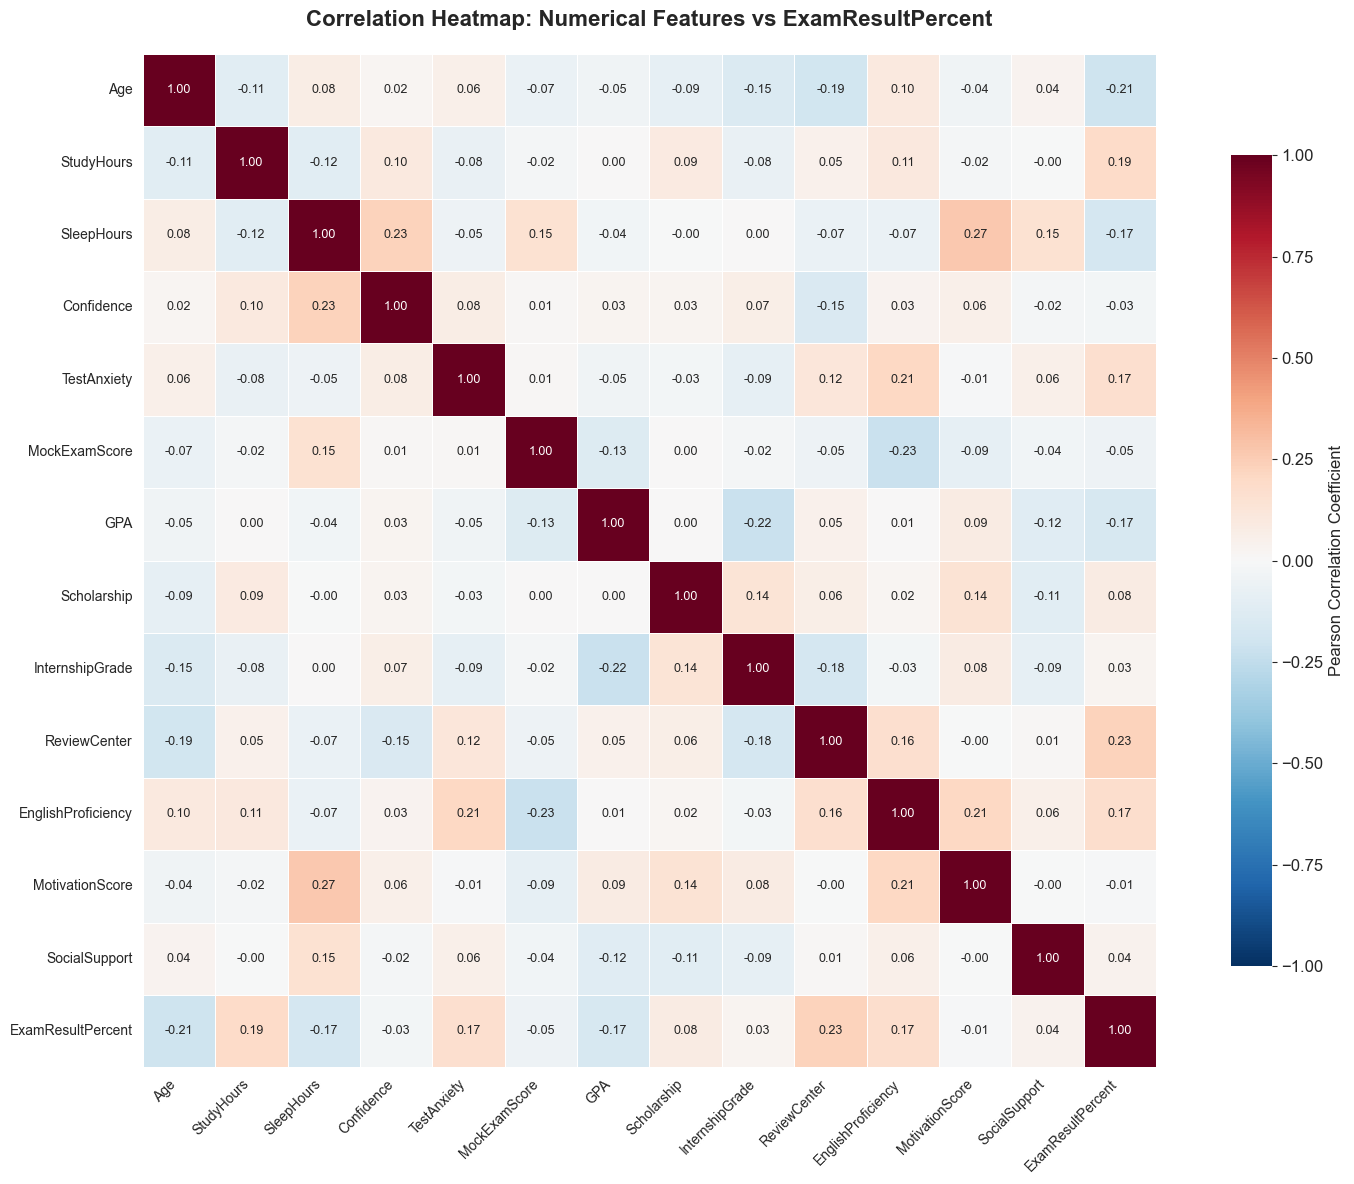

Heatmap saved to ../correlation_analysis_dataset/correlation_heatmap.png


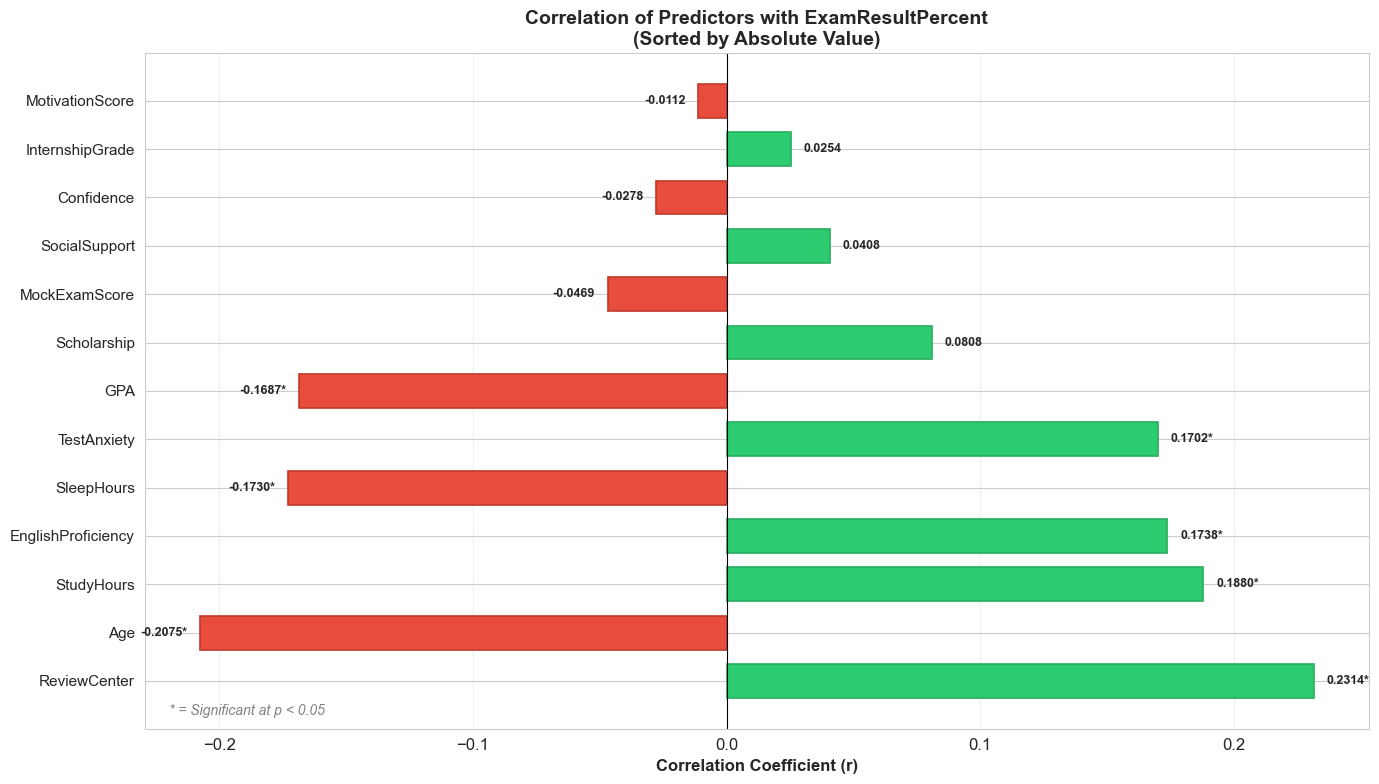

Bar chart saved to ../correlation_analysis_dataset/correlation_bar_chart.png


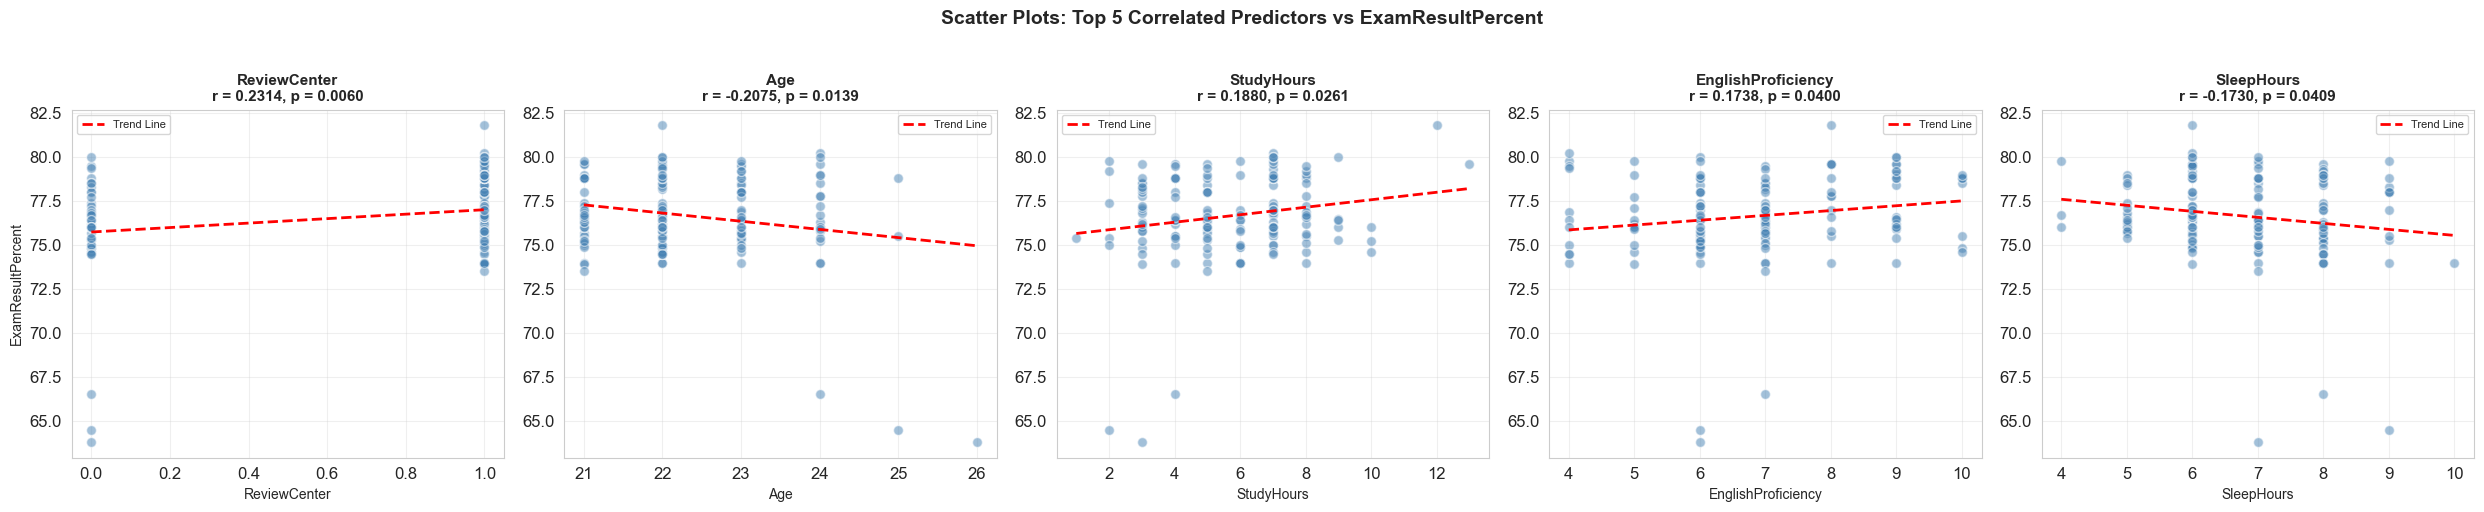

Scatter plots saved to ../correlation_analysis_dataset/top5_scatter_plots.png
Correlation table saved to ../correlation_analysis_dataset/correlation_analysis_results.csv
Descriptive statistics saved to ../correlation_analysis_dataset/descriptive_statistics.csv
Correlation matrix saved to ../correlation_analysis_dataset/correlation_matrix.csv
Text report saved to ../correlation_analysis_dataset/correlation_analysis_report.txt

CORRELATION ANALYSIS COMPLETE
All outputs saved to: ../correlation_analysis_dataset/


In [1]:
# Cell 1 - Import Libraries and Load Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from scipy import stats
from scipy.stats import pearsonr, pointbiserialr

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print('Libraries imported successfully')

# Load dataset
df = pd.read_csv('../data/social_work_exam_dataset.csv')
print(f'Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns')
print(f'\nColumns: {list(df.columns)}')
print(f'\nData Types:\n{df.dtypes}')

# Output directory
output_dir = '../correlation_analysis_dataset'
os.makedirs(output_dir, exist_ok=True)
print(f'\nOutput directory: {output_dir}')

# Cell 2 - Descriptive Statistics

print('=' * 80)
print('DESCRIPTIVE STATISTICS SUMMARY')
print('=' * 80)

# Define numerical features (predictors + target)
numerical_features = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
                      'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade',
                      'ReviewCenter', 'EnglishProficiency', 'MotivationScore',
                      'SocialSupport', 'ExamResultPercent']

# Check missing values before imputation
print('\nMissing Values Per Feature:')
missing_counts = df[numerical_features].isnull().sum()
for col in numerical_features:
    if missing_counts[col] > 0:
        print(f'   {col}: {missing_counts[col]} missing ({missing_counts[col]/len(df)*100:.1f}%)')
print(f'\nTotal missing values: {df[numerical_features].isnull().sum().sum()}')

# Descriptive statistics table
desc_stats = pd.DataFrame({
    'Feature': numerical_features,
    'Count': [df[col].count() for col in numerical_features],
    'Missing': [df[col].isnull().sum() for col in numerical_features],
    'Mean': [df[col].mean() for col in numerical_features],
    'Std. Dev.': [df[col].std() for col in numerical_features],
    'Min': [df[col].min() for col in numerical_features],
    'Q1': [df[col].quantile(0.25) for col in numerical_features],
    'Median': [df[col].median() for col in numerical_features],
    'Q3': [df[col].quantile(0.75) for col in numerical_features],
    'Max': [df[col].max() for col in numerical_features]
})

print('\n')
print(desc_stats.to_string(index=False))
print('\n' + '=' * 80)

# Cell 3 - Handle Missing Values by Median Imputation

print('=' * 80)
print('MISSING VALUE HANDLING - MEDIAN IMPUTATION')
print('=' * 80)

# Store original missing counts for reporting
original_missing = df[numerical_features].isnull().sum()

# Apply median imputation to all numerical features
for col in numerical_features:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f'   {col}: imputed {original_missing[col]} missing values with median = {median_val}')

# Verify no missing values remain
remaining_missing = df[numerical_features].isnull().sum().sum()
print(f'\nRemaining missing values after imputation: {remaining_missing}')
print('=' * 80)

# Cell 4 - Identify Binary vs Continuous Features

print('=' * 80)
print('FEATURE CLASSIFICATION: BINARY vs CONTINUOUS')
print('=' * 80)

# Define predictor features (exclude target)
predictor_features = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
                      'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade',
                      'ReviewCenter', 'EnglishProficiency', 'MotivationScore',
                      'SocialSupport']

target = 'ExamResultPercent'

# Classify features as binary or continuous
binary_features = []
continuous_features = []

for col in predictor_features:
    unique_vals = sorted(df[col].unique())
    if len(unique_vals) == 2 and set(unique_vals) == {0, 1}:
        binary_features.append(col)
    else:
        continuous_features.append(col)

print(f'\nBinary Features ({len(binary_features)}):')
for f in binary_features:
    print(f'   - {f} (values: {sorted(df[f].unique())})')

print(f'\nContinuous Features ({len(continuous_features)}):')
for f in continuous_features:
    print(f'   - {f} (unique values: {df[f].nunique()})')

print('\n' + '=' * 80)

# Cell 5 - Compute Pearson and Point-Biserial Correlations with p-values

print('=' * 80)
print('CORRELATION ANALYSIS: PREDICTORS vs ExamResultPercent')
print('=' * 80)

results = []

# Pearson correlation for continuous predictors
print('\n--- Pearson Correlation (Continuous vs Continuous) ---')
for col in continuous_features:
    r, p_value = pearsonr(df[col], df[target])
    method = 'Pearson'
    interpretation = 'Significant at 0.05' if p_value < 0.05 else 'Not Significant'
    results.append({
        'Feature': col,
        'Method': method,
        'Correlation (r)': round(r, 4),
        'p-value': round(p_value, 6),
        'Interpretation': interpretation
    })
    print(f'   {col}: r = {r:.4f}, p = {p_value:.6f} --> {interpretation}')

# Point-biserial correlation for binary predictors
print('\n--- Point-Biserial Correlation (Binary vs Continuous) ---')
for col in binary_features:
    r, p_value = pointbiserialr(df[col], df[target])
    method = 'Point-Biserial'
    interpretation = 'Significant at 0.05' if p_value < 0.05 else 'Not Significant'
    results.append({
        'Feature': col,
        'Method': method,
        'Correlation (r)': round(r, 4),
        'p-value': round(p_value, 6),
        'Interpretation': interpretation
    })
    print(f'   {col}: r = {r:.4f}, p = {p_value:.6f} --> {interpretation}')

print('\n' + '=' * 80)

# Cell 6 - Output Sorted Correlation Table

print('=' * 80)
print('CORRELATION RESULTS TABLE (Sorted by Absolute Correlation)')
print('=' * 80)

# Build results dataframe and sort by absolute correlation
corr_df = pd.DataFrame(results)
corr_df['|r|'] = corr_df['Correlation (r)'].abs()
corr_df = corr_df.sort_values(by='|r|', ascending=False).reset_index(drop=True)

# Display table
print('\n')
print(corr_df[['Feature', 'Method', 'Correlation (r)', 'p-value', 'Interpretation']].to_string(index=False))
print('\n' + '=' * 80)

# Summary counts
sig_count = corr_df[corr_df['Interpretation'] == 'Significant at 0.05'].shape[0]
not_sig_count = corr_df[corr_df['Interpretation'] == 'Not Significant'].shape[0]
print(f'\nSignificant features (p < 0.05): {sig_count}')
print(f'Not significant features (p >= 0.05): {not_sig_count}')
print(f'Total predictors analyzed: {len(corr_df)}')

# Cell 7 - Top 5 Strongest Correlated Predictors

print('=' * 80)
print('TOP 5 STRONGEST CORRELATED PREDICTORS WITH ExamResultPercent')
print('=' * 80)

top5 = corr_df.head(5)
print('\n')
for idx, row in top5.iterrows():
    direction = 'Positive' if row['Correlation (r)'] > 0 else 'Negative'
    print(f'   {idx+1}. {row["Feature"]}')
    print(f'      Method: {row["Method"]}')
    print(f'      r = {row["Correlation (r)"]:.4f} ({direction})')
    print(f'      p-value = {row["p-value"]:.6f}')
    print(f'      Status: {row["Interpretation"]}')
    print()

print('=' * 80)

# Cell 8 - Correlation Heatmap (All Numerical Features)

# Compute full correlation matrix for all numerical features
all_features = predictor_features + [target]
corr_matrix = df[all_features].corr(method='pearson')

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 12))

mask = np.zeros_like(corr_matrix, dtype=bool)

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Pearson Correlation Coefficient', 'shrink': 0.8},
    ax=ax,
    annot_kws={'size': 9}
)

ax.set_title('Correlation Heatmap: Numerical Features vs ExamResultPercent',
             fontweight='bold', fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Heatmap saved to {output_dir}/correlation_heatmap.png')

# Cell 9 - Correlation Bar Chart (Predictors vs Target)

# Bar chart of correlation coefficients sorted by absolute value
fig, ax = plt.subplots(figsize=(14, 8))

bar_data = corr_df.copy()
colors = ['#2ecc71' if r > 0 else '#e74c3c' for r in bar_data['Correlation (r)']]
edge_colors = ['#27ae60' if r > 0 else '#c0392b' for r in bar_data['Correlation (r)']]

bars = ax.barh(
    range(len(bar_data)),
    bar_data['Correlation (r)'],
    color=colors,
    edgecolor=edge_colors,
    linewidth=1.2,
    height=0.7
)

ax.set_yticks(range(len(bar_data)))
ax.set_yticklabels(bar_data['Feature'], fontsize=11)
ax.set_xlabel('Correlation Coefficient (r)', fontweight='bold', fontsize=12)
ax.set_title('Correlation of Predictors with ExamResultPercent\n(Sorted by Absolute Value)',
             fontweight='bold', fontsize=14)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (val, pval) in enumerate(zip(bar_data['Correlation (r)'], bar_data['p-value'])):
    sig_marker = '*' if pval < 0.05 else ''
    offset = 0.005 if val >= 0 else -0.005
    ha = 'left' if val >= 0 else 'right'
    ax.text(val + offset, i, f'{val:.4f}{sig_marker}', va='center', ha=ha, fontsize=9, fontweight='bold')

# Legend for significance
ax.text(0.02, 0.02, '* = Significant at p < 0.05', transform=ax.transAxes,
        fontsize=10, fontstyle='italic', color='gray')

plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Bar chart saved to {output_dir}/correlation_bar_chart.png')

# Cell 10 - Scatter Plots for Top 5 Predictors

top5_features = corr_df.head(5)['Feature'].tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, feature in enumerate(top5_features):
    ax = axes[idx]
    ax.scatter(df[feature], df[target], alpha=0.5, color='steelblue', edgecolor='white', s=50)

    # Add regression line
    z = np.polyfit(df[feature], df[target], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[feature].min(), df[feature].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend Line')

    # Get correlation info
    row = corr_df[corr_df['Feature'] == feature].iloc[0]
    ax.set_title(f'{feature}\nr = {row["Correlation (r)"]:.4f}, p = {row["p-value"]:.4f}',
                 fontweight='bold', fontsize=11)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel(target if idx == 0 else '', fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Scatter Plots: Top 5 Correlated Predictors vs ExamResultPercent',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/top5_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Scatter plots saved to {output_dir}/top5_scatter_plots.png')

# Cell 11 - Save Results to CSV and Text Report

# Save correlation table to CSV
output_table = corr_df[['Feature', 'Method', 'Correlation (r)', 'p-value', 'Interpretation']].copy()
output_table.to_csv(f'{output_dir}/correlation_analysis_results.csv', index=False)
print(f'Correlation table saved to {output_dir}/correlation_analysis_results.csv')

# Save descriptive statistics to CSV
desc_stats.to_csv(f'{output_dir}/descriptive_statistics.csv', index=False)
print(f'Descriptive statistics saved to {output_dir}/descriptive_statistics.csv')

# Save full correlation matrix to CSV
corr_matrix.to_csv(f'{output_dir}/correlation_matrix.csv')
print(f'Correlation matrix saved to {output_dir}/correlation_matrix.csv')

# Generate comprehensive text report
with open(f'{output_dir}/correlation_analysis_report.txt', 'w') as f:
    f.write('CORRELATION ANALYSIS REPORT\n')
    f.write('=' * 80 + '\n')
    f.write(f'Dataset: social_work_exam_dataset.csv\n')
    f.write(f'Total Records: {df.shape[0]}\n')
    f.write(f'Total Features: {df.shape[1]}\n')
    f.write(f'Target Variable: ExamResultPercent\n')
    f.write(f'Significance Level: alpha = 0.05\n')
    f.write('=' * 80 + '\n\n')

    f.write('1. DESCRIPTIVE STATISTICS\n')
    f.write('-' * 80 + '\n')
    f.write(desc_stats.to_string(index=False))
    f.write('\n\n')

    f.write('2. MISSING VALUE HANDLING\n')
    f.write('-' * 80 + '\n')
    f.write('Method: Median Imputation\n')
    for col in numerical_features:
        if original_missing[col] > 0:
            f.write(f'   {col}: {original_missing[col]} values imputed with median\n')
    f.write('\n')

    f.write('3. FEATURE CLASSIFICATION\n')
    f.write('-' * 80 + '\n')
    f.write(f'Binary Features: {", ".join(binary_features)}\n')
    f.write(f'Continuous Features: {", ".join(continuous_features)}\n\n')

    f.write('4. CORRELATION RESULTS (Sorted by |r|)\n')
    f.write('-' * 80 + '\n')
    f.write('Method: Pearson for continuous, Point-Biserial for binary predictors\n\n')
    f.write(output_table.to_string(index=False))
    f.write('\n\n')

    f.write(f'Significant features (p < 0.05): {sig_count}\n')
    f.write(f'Not significant features (p >= 0.05): {not_sig_count}\n\n')

    f.write('5. TOP 5 STRONGEST CORRELATED PREDICTORS\n')
    f.write('-' * 80 + '\n')
    for idx, row in corr_df.head(5).iterrows():
        direction = 'Positive' if row['Correlation (r)'] > 0 else 'Negative'
        f.write(f'   {idx+1}. {row["Feature"]} (r = {row["Correlation (r)"]:.4f}, '
                f'p = {row["p-value"]:.6f}, {direction}, {row["Method"]})\n')
    f.write('\n')
    f.write('=' * 80 + '\n')
    f.write('END OF REPORT\n')

print(f'Text report saved to {output_dir}/correlation_analysis_report.txt')
print('\nCORRELATION ANALYSIS COMPLETE')
print(f'All outputs saved to: {output_dir}/')

